In [1]:
import nest_asyncio
nest_asyncio.apply()
# required for running async playwright in a jupyter notebook

In [2]:
# import os
# os.environ['OPENAI_API_KEY'] = ''

In [3]:
import re
import os
import json
import base64
import asyncio
import platform
import requests
import playwright
import numpy as np
import pandas as pd
import datetime as dt

from enum import Enum
from typing import List
from typing import Dict
from typing import Union
from typing import Optional
from typing import TypedDict
from operator import itemgetter
from playwright.async_api import Page
from playwright.async_api import async_playwright

from IPython import display
from IPython.display import HTML
from IPython.display import Image

from langchain import hub
from langgraph.graph import END
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI

from langchain.prompts import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import MessagesPlaceholder
from langchain.prompts import HumanMessagePromptTemplate
from langchain.prompts import SystemMessagePromptTemplate

from langchain_core.messages import BaseMessage
from langchain_core.messages import SystemMessage

from langchain_core.pydantic_v1 import Field
from langchain_core.pydantic_v1 import BaseModel

from langchain_core.messages.ai import AIMessage
from langchain_core.messages.chat import ChatMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain_core.messages.function import FunctionMessage
from langchain_core.prompts.image import ImagePromptTemplate

from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.graph import CurveStyle
from langchain_core.runnables.graph import NodeColors
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.runnables import chain as chain_decorator

from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser


In [4]:
class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


class AgentState(TypedDict):
    page: Page # The playwright web page lets us interact with the web environment
    input: str # user request
    img: str # b64 encoded screenshot
    bboxes: List[BBox] # the bounding boxes from the browser annotation function
    prediction: Prediction # the agent's output
    scratchpad: List[BaseMessage] # list of messages to extract additional information from
    observation: str # the most recent response from a tool

## Tools
The agent has 6 simple tools
1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (google)

In [5]:
async def click(state: AgentState) -> str:
    # click [numerical label]
    page = state['page']
    click_args = state['prediction']['args']
    if click_args is None or len(click_args) != 1:
        return f'Failed to click bounding box labeled as number {click_args}'
    
    bbox_id = int(click_args[0])
    try:
        bbox = state['bboxes'][bbox_id]
    except:
        return f'Error: no bbox for : {bbox_id}'
    x, y = bbox['x'], bbox['y']
    res = await page.mouse.click(x, y)

    # in the paper they automatically parse any downloaded PDFs
    # we could add something similar here as well and generally improve response format
    return f'Clicked {bbox_id}'

async def type_text(state: AgentState) -> str:
    page = state['page']
    type_args = state['prediction']['args']
    if type_args is None or len(type_args) != 2:
        return f'Failed to type in element from bounding box labeled as number {type_args}'
    
    bbox_id = int(type_args[0])
    bbox = state['bboxes'][bbox_id]
    x, y = bbox['x'], bbox['y']
    text_content = type_args[1]
    await page.mouse.click(x, y)

    # check if MacOS
    select_all = 'Meta+A' if platform.system() == 'Darwin' else 'Control+A'
    await page.keyboard.press(select_all)
    await page.keyboard.press('Backspace')
    await page.keyboard.type(text_content)
    await page.keyboard.press('Enter')
    return f'Typed {text_content} and submitted'

async def scroll(state: AgentState):
    page = state['page']
    scroll_args = state['prediction']['args']
    if scroll_args is None or len(scroll_args) != 2:
        return 'Failed to scroll due to incorrect arguments'
    
    target, direction = scroll_args

    if target.upper() == 'WINDOW':
        # not sure of the best value for this
        # should have feedback of some sort
        scroll_amount = 500
        scroll_direction = -scroll_amount if direction.lower() == 'up' else scroll_amount
        await page.evaluate(f'window.scrollBy(0, {scroll_direction})')
    else:
        # scroll within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state['bboxes'][target]
        x, y = bbox['x'], bbox['y']
        scroll_direction = -scroll_amount if direction.lower() == 'up' else scroll_amount

        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f'Scrolled {direction} in {"window" if target.upper() == "WINDOW" else "element"}'

async def wait(state: AgentState) -> str:
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f'Waited for {sleep_time}s'

async def go_back(state: AgentState) -> str:
    page = state['page']
    await page.go_back()
    return f'Navigated back a page to {page.url}.'

async def to_google(state: AgentState) -> str:
    page = state['page']
    await page.goto('https://www.google.com/')
    return 'Navigated to google.com'

# Define Agent
The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects
1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action

### Browser annotations
This function annotates all buttons, inputs, text areas etc with numbered bounding boxes. GPT-4V then just has to refer to a bounding box when taking actions, reducing the complexity of the overall task

In [6]:
# some javascript will run on each step to take a screenshot of the page,
# select the elements to annotate, and add bounding boxes
with open('mark_page.js') as f:
    mark_page_script = f.read()

In [7]:
@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate('markPage()')
            break
        except:
            # may be loading
            asyncio.sleep(3)

    screenshot = await page.screenshot()

    # ensure the bboxes don't follow us around
    await page.evaluate('unmarkPage()')
    return {
        'img': base64.b64encode(screenshot).decode(),
        'bboxes': bboxes
    }

In [8]:
async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state['page'])
    return {**state, **marked_page}

def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state['bboxes']):
        text = bbox.get('ariaLabel') or ''
        if not text.strip():
            text = bbox['text']
        el_type = bbox.get('type')
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = '\nValid Bounding Boxes: \n' + '\n'.join(labels)
    return {**state, 'bbox_descriptions': bbox_descriptions}

def parse(text: str) -> dict:
    action_prefix = 'Action: '
    if not text.strip().split('\n')[-1].startswith(action_prefix):
        return {'action': 'retry', 'args': f'Could not parse LLM output: {text}'}
    action_block = text.strip().split('\n')[-1]

    action_str = action_block[len(action_prefix):]
    split_output = action_str.split(' ', 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()

    if action_input is not None: # semicolon separated arguments
        action_input = [inp.strip().strip('[]') for inp in action_input.strip().split(';')]

    return {'action': action, 'args': action_input}

In [9]:
# we will need a later version of langchain to pull this image prompt template
# prompt = hub.pull('wfh/web-voyager')

In [10]:
crawler_prompt_text = '''Imagine you are a robot browsing the web, just like humans. Now you need to complete a task.
In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts.
This screenshot will feature Numerical Labels placed in the TOP LEFT corner of each Web Element.
Carefully analyze the visual information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow the guidelines and choose one of the following actions:

1. Click on the Web Element
2. Delete existing content in a textbox and then type content.
3. Scroll up or down
4. Wait
5. Go back
6. Return to google to start over
7. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack 
- Google 
- ANSWER; [content]

Key guidelines you MUST follow:

* Action guidelines *
1) Execute only one action per interaction.
2) When clicking or typing, ensure to select the correct bounding box.
3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are coloured the same.

* Web Browsing guidelines *
1) Don't interact with useless Web Elements like Login, Sign-in, donation that appear in Webpages.
2) Select strategically to minimize time wasted.

Your reply should strictly follow the format:

Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}
Action: {{One Action format you choose}}
Then the User will provide:
Observation: {{A labeled screenshot given by the User}}
'''

In [11]:
prompt = ChatPromptTemplate(
    input_variables=['bbox_descriptions', 'img', 'input'],
    input_types={'scratchpad': List[Union[AIMessage, HumanMessage, ChatMessage, SystemMessage, FunctionMessage, ToolMessage]]},
    partial_variables={'scratchpad': []},
    messages=[
        SystemMessagePromptTemplate(prompt=[PromptTemplate(input_variables=[], template=crawler_prompt_text)]),
        MessagesPlaceholder(variable_name='scratchpad', optional=True),
        HumanMessagePromptTemplate(prompt=[
            ImagePromptTemplate(input_variables=['img'], template={'url': 'data:image/png;base64,{img}'}),
            PromptTemplate(input_variables=['bbox_descriptions'], template='{bbox_descriptions}'),
            PromptTemplate(input_variables=['input'], template='{input}')])
    ]
)

In [12]:
llm = ChatOpenAI(model='gpt-4-vision-preview', max_tokens=4096)

In [13]:
agent = annotate | RunnablePassthrough.assign(prediction=format_descriptions | prompt | llm | StrOutputParser() | parse)

In [14]:
# display(
#     Image(
#         agent.get_graph().draw_mermaid_png(
#             draw_method=MermaidDrawMethod.API
#         )
#     )
# )
print(agent.get_graph().draw_ascii())


                           +----------------+                    
                           | annotate_input |                    
                           +----------------+                    
                                    *                            
                                    *                            
                                    *                            
                       +------------------------+                
                       | Lambda(afunc=annotate) |                
                       +------------------------+                
                                    *                            
                                    *                            
                                    *                            
                     +---------------------------+               
                     | Parallel<prediction>Input |               
                     +---------------------------+               
          

## Define graph
We need one more function to define that will help is update the graph state after a tool is called


In [15]:
def update_scratchpad(state: AgentState) -> dict:
    '''After a tool is invoked, we want to update the scratchpad so the agent is aware of its previous steps'''
    old = state.get('scratchpad')

    if old:
        txt = old[0].content
        last_line = txt.rsplit('\n', 1)[-1]
        step = int(re.match(r'\d+', last_line).group()) + 1
    else:
        txt = 'Previous action observations:\n'
        step = 1
    txt += f'\n{step}. {state["observation"]}'

    return {**state, 'scratchpad': [SystemMessage(content=txt)]}

In [16]:
workflow = StateGraph(AgentState)

workflow.add_node('agent', agent)
workflow.set_entry_point('agent')
workflow.add_node('update_scratchpad', update_scratchpad)
workflow.add_edge('update_scratchpad', 'agent')

tools = {
    'Click': click,
    'Type': type_text,
    'Scroll': scroll,
    'Wait': wait,
    'GoBack': go_back,
    'Google': to_google
}

for node_name, tool in tools.items():
    workflow.add_node(
        node_name,
        # the lambda ensures the function's string output is mapped to the 'observation' key in the AgentState
        RunnableLambda(tool) | (lambda observation: {'observation': observation})
    )
    # always return to the agent (by means of the update-scratchpad node)
    workflow.add_edge(node_name, 'update_scratchpad')

def select_tool(state: AgentState):
    '''any time the agent completes, this function is called to route the output to a tool or to the end user'''
    action = state['prediction']['action']
    if action == 'ANSWER':
        return END
    if action == 'retry':
        return 'agent'
    return action

workflow.add_conditional_edges('agent', select_tool)
graph = workflow.compile()

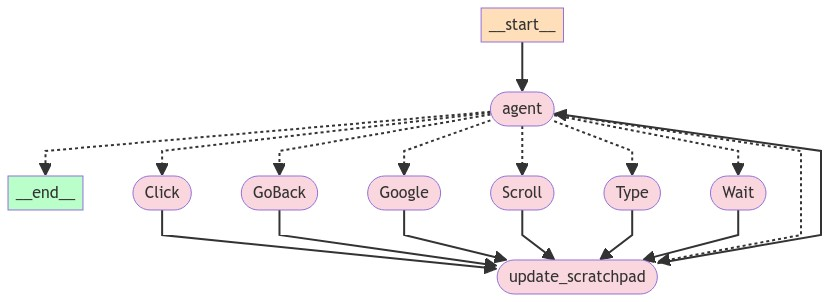

In [17]:
display.display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [18]:
# finished creating agent executor. begin at google.com and let it control the rest
browser = await async_playwright().start()
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto('https://www.google.com')

async def call_agent(question: str, page, max_steps: int=150):
    event_stream = graph.astream(
        {
            'page': page,
            'input': question,
            'scratchpad': []
        },
        {
            'recursion_limit': max_steps
        }
    )
    final_answer = None
    steps = []

    async for event in event_stream:
        if 'agent' not in event:
            continue
        pred = event['agent'].get('prediction') or {}
        action = pred.get('action')
        action_input = pred.get('args')
        display.clear_output(wait=False)
        steps.append(f'{len(steps) + 1}. {action}: {action_input}')
        print('\n'.join(steps))
        display.display(Image(base64.b64decode(event['agent']['img'])))
        if 'ANSWER' in action:
            final_answer = action_input[0]
            break

    return final_answer

1. Type: ['7', 'Ayrton Senna Wikipedia']
2. Click: ['16']
3. Click: ['17']
4. Click: ['12']


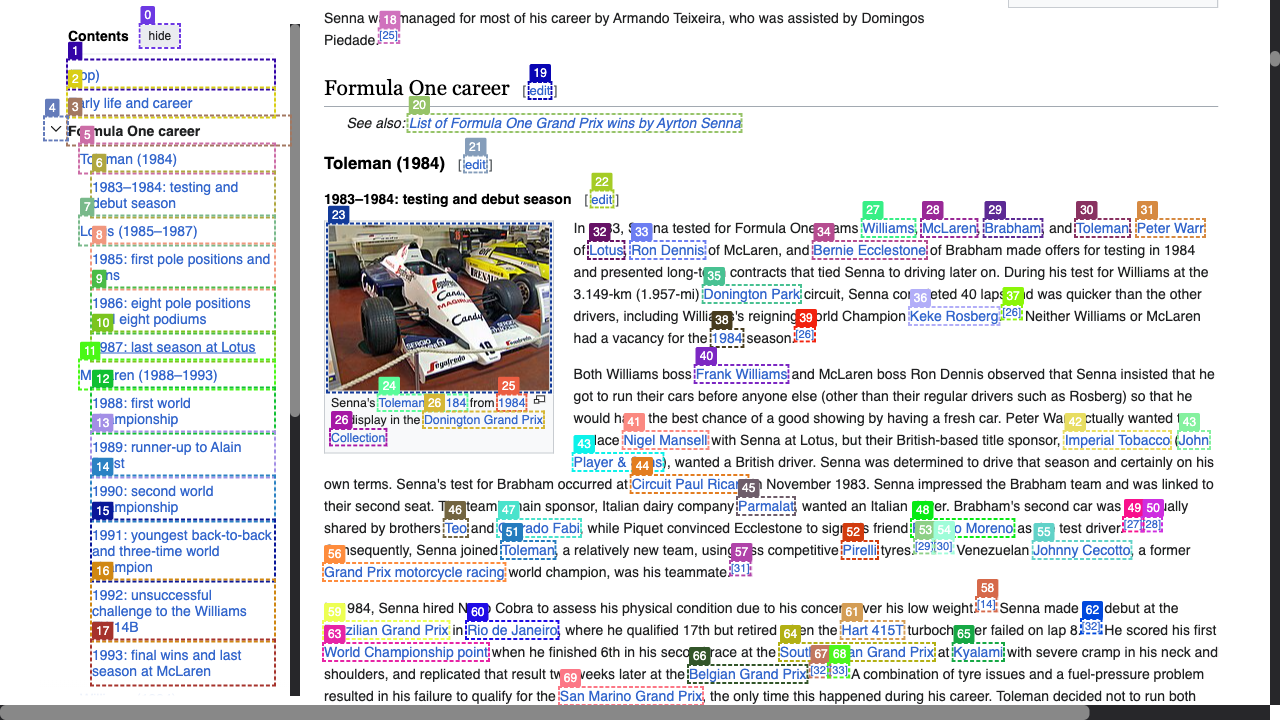

In [19]:
res = await call_agent('Write a few paragraphs on the heroics of Ayrton Senna. You may use wikipedia for research', page)
print(f'Final response: {res}')